In [1]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm



files = Path("agg_data").glob("ParlaMint-*.speeches.jsonl")
files = list(files)
dfs = []


for file in tqdm(files):
  df = pd.read_json(file,
                    lines=True,
                    # nrows=10000,
                    )
  df["country"] = str(file).split("ParlaMint-")[-1].split(".speeches")[0]
  df = pd.concat([df, df.metadata.apply(pd.Series)], axis=1)
  dfs.append(
    df
  )
df = pd.concat(dfs).reset_index(drop=True)
print(df.shape)

100%|██████████| 29/29 [46:53<00:00, 97.00s/it]  


(8300531, 29)


In [2]:
countries = ["AT", "BA", "BE", "BG", "CZ", "DK", "EE", "ES-CT", "ES-GA", "ES-PV", "ES", "FI", "FR", "GB", "GR", "HR", "HU", "IS", "IT", "LV", "NL", "NO", "PL", "PT", "RS", "SE", "SI", "TR", "UA", ]

lattitudes = [ 47.33, 44, 50.83, 43, 49.75, 56, 59, 40, 40, 40, 40, 64, 46, 54, 39, 45.17, 47, 65, 42.83, 57, 52.5, 62, 52, 39.5, 44, 62, 46, 39, 49,]
mapper = {k: v for k, v in zip(countries, lattitudes)}

In [18]:
# Filtering
# Keep only MPs
c1 = df.Speaker_MP == "MP"

# Exclude non-national parliaments:
c2 = ~df.country.isin(["ES-CT", "ES-GA", "ES-PV", ])

# Exclude chairs:
c3 = df.Speaker_role == "Regular"

df = df[c1&c2&c3]

def map_sentiment_to_category(logit: float) -> str:
    if logit < 2:
        return "Negative"
    elif 2 <= logit < 4:
        return "Neutral"
    else:
        return "Positive"
df["sentiment_categorical"] = df.logits_pondered.apply(map_sentiment_to_category)


def percentage_of_neutral(l: pd.Series) -> float:
    return (l == "Neutral").sum()/l.shape[0]
def percentage_of_negative(l: pd.Series) -> float:
    return (l == "Negative").sum()/l.shape[0]
def percentage_of_positive(l: pd.Series) -> float:
    return (l == "Positive").sum()/l.shape[0]
def get_female_average_per_country(df: pd.DataFrame, country: str)-> float:
    c1 = df.country == country
    c2 = df.Speaker_gender


gb1 = df.groupby("country").agg({
    "logits_pondered": "mean",
    "sentiment_categorical": [percentage_of_positive, percentage_of_neutral, percentage_of_negative]
}).reset_index()
gb1.columns = "country average_sentiment percentage_of_positive percentage_of_neutral percentage_of_negative".split()



gb2 = df.groupby(["country", "Speaker_gender"]).agg({
    "logits_pondered": "mean"
}).reset_index()


gb1["average_female_sentiment"] = gb1.merge(gb2[gb2.Speaker_gender == "F"], on="country", how="outer").logits_pondered
gb1["average_male_sentiment"] = gb1.merge(gb2[gb2.Speaker_gender == "M"], on="country", how="outer").logits_pondered
gb1["male - female"] = gb1.average_male_sentiment - gb1.average_female_sentiment
gb1["lattitude"] = [mapper.get(i) for i in gb1.country]
gb1

,country,average_sentiment,percentage_of_positive,percentage_of_neutral,percentage_of_negative,average_female_sentiment,average_male_sentiment,male - female,lattitude
0,AT,2.129325,0.031388,0.473337,0.495275,2.210399,2.093508,-0.116890,47.33
1,BA,2.213168,0.047828,0.511696,0.440476,2.090905,2.233633,0.142729,44.00
2,BE,2.002218,0.043963,0.407319,0.548718,2.038480,1.978530,-0.059950,50.83
3,BG,2.264898,0.072697,0.513357,0.413946,2.545127,2.176639,-0.368488,43.00
4,CZ,2.138461,0.027153,0.500582,0.472265,2.197720,2.123622,-0.074098,49.75
5,DK,1.998965,0.035374,0.436198,0.528429,2.021255,1.987691,-0.033564,56.00
6,EE,1.832211,0.011920,0.377429,0.610651,1.911975,1.807862,-0.104113,59.00
7,ES,1.905895,0.057296,0.357545,0.585160,2.008476,1.844670,-0.163806,40.00
8,FI,2.257844,0.043077,0.540796,0.416127,2.239578,2.272110,0.032532,64.00
9,FR,2.273819,0.052954,0.592531,0.354515,2.298606,2.265519,-0.033087,46.00


/home/peterr/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


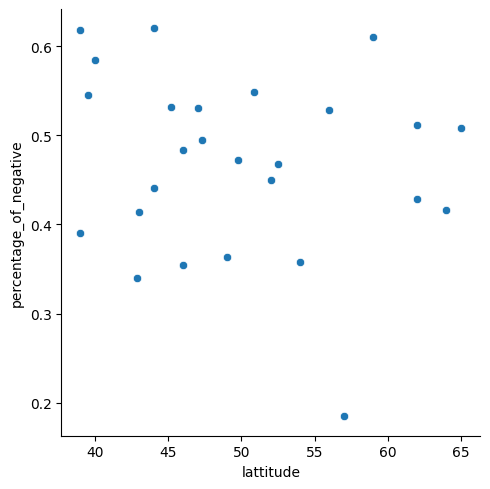

In [19]:
import seaborn as sns

sns.relplot(
    data=gb1,
    x="lattitude",
    y="percentage_of_negative",
    kind="scatter",
)